# Reprojecting geographic data {#sec-reproj-geo-data}

## Prerequisites

In [1]:
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 6
pd.options.display.max_columns = 6
pd.options.display.max_colwidth = 35
plt.rcParams['figure.figsize'] = (5, 5)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import shapely.geometry
import geopandas as gpd
import rasterio
import rasterio.warp
from rasterio.plot import show
import pyproj

In [3]:
# 出现错误CRSError: Invalid projection: epsg:4326: 的解决方案
# 因为装了多个版本的pyproj
# 在anaconda的目录下搜一下其他的proj.db文件的路径
# 复制路径在所装的环境文件夹下的Library文件夹下的那个路径，使用pyproj.datadir.set_data_dir()来更新目录
import pyproj
# pyproj.datadir.get_data_dir()
path = 'D:\work\miniconda3\Library\share\proj'
pyproj.datadir.set_data_dir(path)

In [4]:
src_srtm = rasterio.open('data/srtm.tif')
src_nlcd = rasterio.open('data/nlcd.tif')
zion = gpd.read_file('data/zion.gpkg')
world = gpd.read_file('data/world.gpkg')
cycle_hire_osm = gpd.read_file('data/cycle_hire_osm.gpkg')

## 介绍
@sec-coordinate-reference-systems 引入了坐标参考系统（CRS），重点关注两种主要类型：地理（“经度/纬度”，单位为经度和纬度）和投影（通常以米为单位） 基准）坐标系。 本章以这些知识为基础并进行了更深入的探讨。 它演示了如何设置地理数据并将其从一种 CRS 转换为另一种 CRS，此外，还强调了您应该注意的由于忽略 CRS 而可能出现的特定问题，特别是当您的数据使用经度/纬度坐标存储时。

在许多项目中，无需担心不同的 CRS，更不用说在不同的 CRS 之间进行转换。 了解您的数据是否位于投影坐标系或地理坐标系中以及其对几何操作的影响非常重要。 但是，如果您了解数据的 CRS 以及几何操作的后果（在下一节中介绍），CRS 应该在幕后工作：当出现问题时，人们通常会突然需要了解 CRS。 拥有一个包含所有项目数据的明确定义的项目 CRS，再加上了解如何以及为何使用不同的 CRS，可以确保不会出错。 此外，学习坐标系将加深您对地理数据集以及如何有效使用它们的了解。

本章讲述 CRS 的基础知识，演示使用不同 CRS 的后果（包括可能出错的地方），以及如何将数据集从一个坐标系“重新投影”到另一个坐标系。 在下一节中，我们将介绍 Python 中的 CRS，然后介绍 @sec-querying-and-setting-coordinate-systems，它展示了如何获取和设置与空间对象关联的 CRS。 @sec-geometry-operations-on-projected-and-unprojected-data 部分参考创建缓冲区的工作示例演示了了解数据所在 CRS 的重要性。 我们分别在@sec-when-to-reproject 节和@sec-which-crs-to-use 节中解决何时重新投影以及使用哪个CRS 的问题。 我们在 @sec-reprojecting-vector-geometries 和 @sec-reprojecting-raster-geometries 部分介绍了重新投影矢量和栅格对象，并在 @sec-custom-map-projections 中介绍了修改地图投影。


## 坐标参考系

大多数需要 CRS 转换的现代地理工具，包括 Python 包和 QGIS 等桌面 GIS 软件，都与 [PROJ](https://proj.org/) 接口，这是一个开源 C++ 库，“从一个坐标参考系统转换坐标” (CRS) 到另一个”。 CRS 可以通过多种方式进行描述，包括以下几种。

* 简单但可能含糊不清的陈述，例如“它位于经/纬度坐标中”。
* 正式但现已过时的“proj4 字符串”，例如“+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs”。
* 使用识别“权限：代码”文本字符串，例如“EPSG：4326”。

每个都指的是同一件事：构成全球定位系统 (GPS) 坐标和许多其他数据集基础的“WGS84”坐标系。 但哪一个是正确的呢？

简而言之，识别 CRS 的第三种方法是正确的：本书中介绍的“geopandas”和“rasterio”包以及许多其他用于处理地理数据的软件项目（包括 [QGIS]（）可以理解“EPSG:4326”） https://docs.qgis.org/3.22/en/docs/user_manual/working_with_projections/working_with_projections.html）和[项目]（https://proj.org/development/quickstart.html）。 “EPSG:4326”是面向未来的。 此外，虽然它是机器可读的，但与 proj 字符串表示形式“EPSG:4326”不同，它很短、易于记住并且在线高度“可找到”（搜索 EPSG:4326 会在网站 [epsg.io]( https://epsg.io/4326），例如）。 “geopandas”和“rasterio”也可以理解更简洁的标识符“4326”，但我们建议使用更明确的“AUTHORITY:CODE”表示形式，以防止歧义并提供上下文。

更长的答案是，这三个描述都不够充分，需要更多细节来明确 CRS 处理和转换：由于 CRS 的复杂性，不可能在如此短的文本字符串中捕获有关它们的所有相关信息。 为此，开放地理空间联盟（OGC，还开发了 sf 包实现的简单功能规范）开发了一种用于描述 CRS 的开放标准格式，称为 WKT（众所周知的文本）。 对此进行了详细说明，该文档“定义了用于坐标参考的抽象模型的文本字符串实现的结构和内容 ISO 19111:2019 中描述的系统”（开放地理空间联盟 2019...添加引用！）。 WGS84 CRS 的 WKT 表示形式（标识符为“EPSG:4326”）如下：



In [5]:
crs = pyproj.CRS.from_string('EPSG:4326') # or '.from_epsg(4326)'
print(crs.to_wkt(pretty=True))

GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    USAGE[
        SCOPE["unknown"],
        AREA["World"],
        BBOX[-90,-180,90,180]],
    ID["EPSG",4326]]


命令的输出显示了 CRS 标识符（也称为空间参考标识符或 [SRID](https://postgis.net/workshops/postgis-intro/projection.html)）的工作原理：它只是一个外观 - 上，提供与 CRS 的更完整的 WKT 表示相关联的唯一标识符。 这就提出了一个问题：如果标识符与 CRS 的较长 WKT 表示形式不匹配，会发生什么情况？ 在这一点上，开放地理空间联盟（2019...添加引用！）很清楚，详细的 WKT 表示优先于 [标识符](https://docs.opengeospatial.org/is/18-010r7/18-010r7 .html#37):

> 如果引用的标识符中给出的任何属性或值与 WKT 描述中明确给出的属性或值相冲突，则以 WKT 值为准。

以 AUTHORITY:CODE 形式引用 CRS 标识符的惯例（也被用其他语言编写的地理软件使用）允许引用广泛的正式定义的坐标系。 26 CRS 标识符中最常用的权威是 EPSG，欧洲石油调查组的缩写，该组织发布了标准化的 CRS 列表（EPSG 由石油和天然气机构[接管](http://wiki.gis.com/wiki/index.php/European_Petroleum_Survey_Group) 国际石油和天然气生产商协会地理信息委员会（……添加引文！），2005 年）。 CRS 标识符中可以使用其他权限。 例如，ESRI:54030 指的是 ESRI 的 Robinson 投影实现，它具有以下 WKT 字符串：

In [6]:
crs = pyproj.CRS.from_string('ESRI:54030')
print(crs.to_wkt(pretty=True))

PROJCRS["World_Robinson",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["Degree",0.0174532925199433]]],
    CONVERSION["World_Robinson",
        METHOD["Robinson"],
        PARAMETER["Longitude of natural origin",0,
            ANGLEUNIT["Degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["False easting",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETER["False northing",0,
            LENGTHUNIT["metre",1],
            ID["EPSG",8807]]],
    CS[Cartesian,2],
        AXIS["(E)",east,
            ORDER[1],
            LENGTHUNIT["metre",1]],
        AXIS["(N)",north,
            ORDER[2],
            LENGTHUNIT["metre",1]],
    USAGE[
        SCOPE["unknown"],
        AREA["World"],
        BBOX[-90,-180,90,180]],
    ID["ESRI",54030]]


WKT 字符串详尽、详细且精确，允许明确的 CRS 存储和转换。 它们包含任何给定 CRS 的所有相关信息，包括其基准面和椭球体、本初子午线、投影和单位。

最近的 PROJ 版本 (6+) 仍然允许使用 proj-string 来定义坐标操作，但一些 proj-string 键（`+nadgrids`、`+towgs84`、`+k`、`+init=epsg:`） 要么不再支持，要么不鼓励。 此外，只能在 proj-string 中直接设置三个数据（即 WGS84、NAD83 和 NAD27）。 有关 CRS 定义和 PROJ 库的演变的详细说明，请参阅 Bivand (2021)、Pebesma 和 Bivand (2022) 的第 2 章以及 Floris Vanderhaeghe 的博客文章（...添加引用！）。 正如 [PROJ 文档](https://proj.org/development/reference/cpp/cpp_general.html) 中所述，WKT CRS 格式有不同版本，包括 WKT1 和 WKT2 的两个变体，后者 (WKT2 ，2018 规范）对应于 ISO 19111:2019（开放地理空间联盟 2019...添加引用！）。

## 查询和设置坐标系

让我们看看 CRS 如何存储在 Python 空间对象中以及如何查询和设置它们。 首先，我们将了解在矢量地理数据对象中获取和设置 CRS。 考虑名为“world”的“GeoDataFrame”对象，它是从文件“world.gpkg”导入的。 对象“world”代表全世界的国家。 可以使用“.crs”属性检索其 CRS：

In [7]:
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

输出指定以下信息：

1. CRS 类型（“地理 2D CRS”）和 EPSG 代码（“EPSG:4326”）
1. CRS 名称（`WGS 84`）
1. 坐标轴（“纬度”、“经度”）及其单位（“度”）
1.适用的区域名称（`World`）和边界框（`(-180.0, -90.0, 180.0, 90.0)`）
1. 数据（`WGS 84`）

WKT 表示形式在将对象保存到文件或执行任何坐标操作时在内部使用，可以使用“.crs.to_wkt()”进行提取，如上所示 (@sec-coordinate-reference-systems)。 在上面，我们可以看到“world”对象具有 WGS84 椭球体，使用格林威治本初子午线以及纬度和经度轴顺序。 我们还有适合使用此 CRS 的区域规范，以及 CRS 标识符：“EPSG:4326”。

CRS 规范对象（例如“world.crs”）具有其他几个有用的属性和方法来检索有关所用 CRS 的附加信息。 例如，尝试运行：

* `world.crs.is_geographic` 用于检查 CRS 是否是地理的
* `world.crs.axis_info[0].unit_name` 和 `world.crs.axis_info[1].unit_name` 用于找出两个轴的 CRS 单位（通常具有相同的单位）
* `world.crs.to_authority()` 提取权限（例如，`EPSG`）和标识符（例如，`4326`）
* `world.crs.to_proj4()` 返回 proj 字符串表示形式

如果坐标参考系 (CRS) 丢失或设置了错误的 CRS，可以在“GeoSeries”或“GeoDataFrame”上使用“.set_crs”方法来设置它。 可以使用 EPSG 代码作为第一个参数来指定 CRS。 如果对象已经有不同的 CRS 定义，我们还必须指定“allow_override=True”来替换它（否则我们会收到错误）。 例如，这里我们设置了“EPSG:4326”CRS，这没有任何效果，因为“world”已经具有确切的 CRS 定义：

In [8]:
world2 = world.set_crs(4326)

在这里，我们将现有的“EPSG:4326”定义替换为新定义“EPSG:3857”：

In [9]:
world3 = world.set_crs(3857, allow_override=True)

数字被解释为“EPSG”代码。 我们还可以使用字符串，如“EPSG:4326”，这对于使代码更加清晰以及使用其他权限时很有用：


In [10]:
world4 = world.set_crs('ESRI:54009', allow_override=True)

在“rasterio”中，CRS 信息作为栅格文件连接元数据 (@sec-using-rasterio) 的一部分存储。 通常没有必要替换“rasterio”文件连接的 CRS 定义，因为在任何操作中都不会考虑它，只考虑变换矩阵和坐标。 一个例外是在写入栅格时，在这种情况下，我们需要构造要写入的栅格文件的元数据，并在其中指定 CRS (@sec-raster-from-scratch)。 但是，如果我们出于某种原因需要更改文件连接元数据中的 CRS 定义，我们可以在以“r+”（读取和写入）模式打开文件时执行此操作：

In [11]:
src_nlcd2 = rasterio.open('data/nlcd.tif', 'r+')
src_nlcd2.crs

CRS.from_epsg(3857)

In [12]:
src_nlcd2.crs = 3857
src_nlcd2.crs

CRS.from_epsg(3857)

重要的是，如上所示，“.set_crs”（对于矢量图层）或对“.crs”（对于栅格）的分配不会改变坐标值或几何形状。 他们的作用只是设置一个关于对象CRS的元数据信息。 因此，我们创建的对象“world3”、“world4”和“src_nlcd2”是“不正确的”，因为几何图形实际上是在与相关 CRS 定义中指定的不同的 CRS 中给出的。

在某些情况下，地理对象的 CRS 是未知的，例如在下面的代码块中创建的伦敦数据集的情况，该数据集基于 @sec-vector-layer-from-scratch 中引入的伦敦示例：

In [13]:
lnd_point = shapely.geometry.Point(-0.1, 51.5)
lnd_geom = gpd.GeoSeries([lnd_point])
lnd_layer = gpd.GeoDataFrame({'geometry': lnd_geom})
lnd_layer

,geometry
0,POINT (-0.10000 51.50000)


In [14]:
lnd_layer.crs

最后一个表达式的结果不会打印任何内容，因为“.crs”中 CRS 定义的值为“None”。 这意味着“geopandas”不知道 CRS 是什么，也不愿意猜测。 除非手动指定 CRS 或从具有 CRS 元数据的源加载，否则 `geopandas` 不会对哪些坐标系做出任何明确的假设，除了说“我不知道”。 考虑到可用 CRS 的多样性，这种行为是有意义的，但与某些方法不同，例如 GeoJSON 文件格式规范，它简化了假设所有坐标都有经度/纬度 CRS：“EPSG:4326”。

如上所述，可以使用“.set_crs”方法将 CRS 添加到“GeoSeries”或“GeoDataFrame”对象。 由于缺少定义，我们不需要指定“allow_override=True”，因为没有任何内容可以覆盖。 例如：

In [15]:
lnd_layer = lnd_layer.set_crs(4326)
lnd_layer.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

一般来说，所有地理坐标都有一个坐标系，并且软件只有知道它正在使用什么类型的 CRS，才能围绕绘图和几何操作做出正确的决策。 使用“geopandas”和“rasterio”时，没有指定 CRS 的数据集在大多数工作流程中不是问题，因为只考虑坐标。 用户需要确保在处理多个图层时，所有坐标都在同一 CRS 中给出（无论是否指定）。 不过，在导出结果时，保留 CRS 定义很重要，因为其他软件通常*确实*在计算中使用并需要 CRS 定义。 还应该提到的是，在某些情况下，CRS 规范故意未指定，例如在任意或非地理空间中处理图层时（模拟、内部建筑规划、地块规模生态模式分析等） 。

## 对投影和非投影数据进行几何操作 {#sec-geometry-operations-on-projected-and-unprojected-data}

“geopandas”包通过其依赖项“shapely”假定平面几何形状，并使用假定为 CRS 单位的距离/面积值。
事实上，CRS 定义通常被忽略，并且相应的函数（例如在绘图和距离计算中）应用于“裸露”的“shapely”几何图形。
因此，确保以下几点至关重要：

* 几何计算仅适用于预计的 CRS
* 如果涉及多个层——所有层必须位于相同的（投影的）CRS 中
* 输入的距离和面积值以 CRS 单位传递（以及返回值---以 CRS 单位解释）

例如，要计算伦敦周围 100 $km$ 的缓冲区，我们需要：

* 使用预计 CRS 中代表伦敦的图层（例如“EPSG:27700”）
* 传递 CRS 单位的距离值（例如 `100000` $m$）

在下面的代码部分中，我们从头开始创建一个点图层“lnd_layer_proj”，其中一个点代表伦敦（与我们上面创建的地理 CRS 中的“lnd_layer”相比，请参阅@sec-querying-and-setting-coordinate- 系统）：

In [16]:
lnd_point_proj = shapely.geometry.Point(530000, 180000)
lnd_geom_proj = gpd.GeoSeries([lnd_point_proj], crs=27700)
lnd_layer_proj = gpd.GeoDataFrame({'geometry': lnd_geom_proj})
lnd_layer_proj

,geometry
0,POINT (530000.000 180000.000)


现在我们可以使用`.buffer`方法（@sec-buffers）来计算缓冲区：

In [17]:
lnd_layer_proj_buff = lnd_layer_proj.buffer(100000)
lnd_layer_proj_buff

0    POLYGON ((630000.000 180000.000...
dtype: geometry

生成的缓冲区显示在 @fig-reprojection-geo-proj 的左侧面板中。

计算地理 CRS 中 100-$km$ 缓冲区“lnd_layer”是不可能的。
由于“lnd_layer”以十进制度为单位，因此最接近 100-$km$ 缓冲区的距离是使用 1 度的距离，大致相当于 100 $km$（1 度约为 111 $km$ 赤道）：

In [18]:
lnd_layer_buff = lnd_layer.buffer(1)
lnd_layer_buff

C:\Users\24365\AppData\Local\Temp\ipykernel_27224\855451079.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lnd_layer_buff = lnd_layer.buffer(1)


0    POLYGON ((0.90000 51.50000, 0.8...
dtype: geometry

然而，这是不正确的，正如警告消息所示并显示在 @fig-reprojection-geo-proj 的右侧面板中。
度数和真实距离之间的关联在地球表面各不相同，我们不能假设它是固定的（例如 1 度 = 111 $km$）。

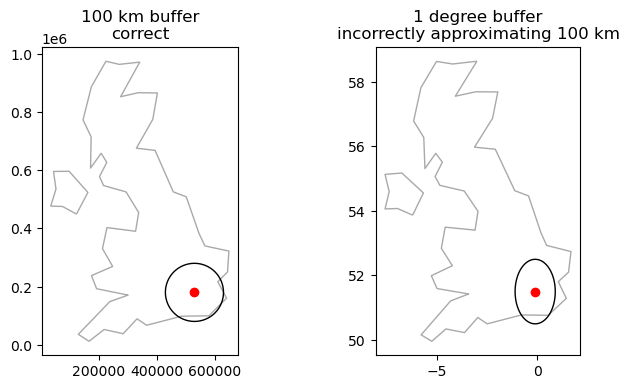

In [19]:
#| label: fig-reprojection-geo-proj
#| fig-cap: Buffers around London, around a projected point and distance of 100 $km$ (left), and around a point in lon/lat using distance of 1 degree (right) which is incorrect.

uk = world[world['name_long'] == 'United Kingdom']
uk_proj = uk.to_crs(27700)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
uk_proj.plot(color='none', edgecolor='darkgrey', ax=axes[0])
lnd_layer_proj.plot(color='red', ax=axes[0])
lnd_layer_proj_buff.plot(color='none', ax=axes[0])
uk.plot(color='none', edgecolor='darkgrey', ax=axes[1])
lnd_layer.plot(color='red', ax=axes[1])
lnd_layer_buff.plot(color='none', ax=axes[1])
axes[0].set_title('100 km buffer\ncorrect')
axes[1].set_title('1 degree buffer\nincorrectly approximating 100 km');

::: {.callout-note}
两条经线（称为子午线）之间的距离在赤道处约为 111 $km$（执行“import geopy.distance;geopy.distance.geodesic((0,0),(0,1))”来查找 精确距离）。
这在两极缩小到零。
例如，在伦敦的纬度，经线相距不到 70 $km$（挑战：执行验证这一点的代码）。
相比之下，无论纬度如何，纬度线彼此等距：它们始终相距 111 $km$ 左右，包括赤道处和两极附近（见图...）。
:::

::: {.callout-note}
[`spherely`](https://github.com/benbovy/spherely) 包正处于开发的早期阶段，旨在提供与 `shapely` 相对应的球面几何形状，以便真实距离（以 $ m$) 和面积（以 $m^2$ 为单位）可以根据地理 CRS 中的几何形状进行计算。
:::

## 何时重新投影？ {#sec-when-to-reproject}

上一节展示了如何使用“lnd_layer.set_crs(4326)”手动设置 CRS。
然而，在实际应用中，CRS 通常在读入数据时自动设置。
在许多项目中，与 CRS 相关的主要任务是将对象从一种 CRS 转换为另一种 CRS。 但什么时候应该转换数据呢？ 并进入哪个 CRS？ 这些问题没有明确的答案，CRS 选择总是涉及权衡（Maling 1992，添加参考文献...）。
但是，本节提供了一些可以帮助您做出决定的一般原则。

首先值得考虑何时转型。 在某些情况下，转换为地理 CRS 至关重要，例如在线发布数据时（例如，使用 Python 包“folium”的基于 Leaflet 的地图）。
另一种情况是必须比较或组合具有不同 CRS 的两个对象，如我们尝试查找具有不同 CRS 的两个对象之间的距离时所示：

In [20]:
lnd_layer.distance(lnd_layer_proj)

C:\Users\24365\AppData\Local\Temp\ipykernel_27224\2145313019.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lnd_layer.distance(lnd_layer_proj)
C:\Users\24365\AppData\Local\Temp\ipykernel_27224\2145313019.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:27700

  lnd_layer.distance(lnd_layer_proj)


0    559715.614087
dtype: float64

我们得到了毫无意义的结果和警告。

为了使“lnd_layer”和“lnd_layer_proj”对象在地理上具有可比性，必须将其中一个对象转换为另一个对象的 CRS。
但该使用哪个 CRS？
答案取决于上下文：许多项目，尤其是涉及网络地图的项目，需要“EPSG:4326”中的输出，在这种情况下，值得转换投影对象。
然而，如果项目需要几何计算，意味着平面几何，例如计算缓冲区（@sec-geometry-operations-on-projected-and-unprojected-data），则有必要将具有地理 CRS 的数据转换为 具有投影 CRS 的等效对象，例如英国国家电网 (`EPSG:27700`)。
这是@sec-reprojecting-raster-geometries 的主题。

## 使用哪个 CRS？ {#sec-which-crs-to-use}

哪个 CRS 的问题很棘手，并且很少有“正确”的答案：“不存在通用的投影，当远离指定帧的中心时，所有投影都会涉及失真”（Bivand、Pebesma 和 Gómez-Rubio 2013 ，添加引用...）。
此外，你不应该只关注每一项任务的一个预测。
可以对分析的某些部分使用一种投影，对不同部分使用另一种投影，甚至可以使用其他投影进行可视化。
始终尝试选择最适合您目标的 CRS！

当选择**地理** CRS 时，答案通常是 [WGS84](https://en.wikipedia.org/wiki/World_Geodetic_System#A_new_World_Geodetic_System:_WGS_84)。
它不仅用于网络制图，还因为此 CRS 默认提供 GPS 数据集以及数千个栅格和矢量数据集。
WGS84 是世界上最常见的 CRS，因此值得了解其 EPSG 代码：4326。
这个“神奇数字”可用于将具有不寻常的投影 CRS 的对象转换为广泛理解的对象。

当需要**预计** CRS 时该怎么办？
在某些情况下，这不是我们可以自由决定的事情：“通常投影的选择是由公共制图机构做出的”（Bivand、Pebesma 和 Gómez-Rubio 2013，添加引用...）。
这意味着，在使用本地数据源时，最好使用提供数据的 CRS，以确保兼容性，即使官方 CRS 不是最准确的。
伦敦的例子很容易回答，因为：

* 英国国家电网（及其相关 EPSG 代码 27700）是众所周知的，并且
* 原始数据集（`lnd_layer`）已经有该 CRS。

常用的默认值是通用横轴墨卡托坐标系 ([UTM](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system))，它是一组 CRS，将地球划分为 60 个经向楔形和 20 个纬向段。
UTM CRS 使用的横轴墨卡托投影是等角的，但随着距 UTM 区域中心距离的增加，区域和距离的扭曲程度也越来越严重。
因此，GIS 软件 Manifold 的文档建议将使用 UTM 区域的项目的纵向范围限制为距中央子午线 6 度（来源：[manifold.net](http://www.manifold.net/doc/mfd9/universal_transverse_mercator_projection.htm ））。
因此，我们建议仅当您的重点是保持相对较小区域的角度时才使用 UTM！

地球上几乎每个地方都有UTM代码，例如“60H”指的是新西兰北部。
对于北半球位置，UTM EPSG 代码按顺序从 32601 到 32660 运行；对于南半球位置，UTM EPSG 代码从 32701 到 32760 按顺序运行。

为了展示系统如何工作，让我们创建一个函数“lonlat2UTM”来计算与地球上任何点相关的 EPSG 代码，如下所示：

In [21]:
import math
def lonlat2UTM(lon, lat):
    utm = (math.floor((lon + 180) / 6) % 60) + 1
    if lat > 0:
        utm += 32600
    else:
        utm += 32700
    return utm

以下命令使用此函数来识别奥克兰的 UTM 区域和关联的 EPSG 代码：


In [22]:
lonlat2UTM(174.7, -36.9)

32760

这是伦敦的另一个例子（我们将 `lnd_layer` 中第 1^st^ 几何体的坐标“解压”到 `lonlat2UTM` 函数参数中）：


In [23]:
lonlat2UTM(*lnd_layer['geometry'].iloc[0].coords[0])

32630

目前，我们还有工具帮助我们选择合适的 CRS。
例如，网页<https://jjimenezshaw.github.io/crs-explorer/>根据所选位置和类型列出了CRS。
重要提示：虽然这些工具在许多情况下都很有用，但在应用推荐的 CRS 之前，您需要了解其属性。

如果无法立即明确合适的 CRS，则 CRS 的选择应取决于在后续地图和分析中保留的最重要的属性。
所有 CRS 要么是等面积的、等距的、共形的（形状保持不变），要么是这些折衷的某种组合（@sec-投影坐标参考系统）。
可以为感兴趣的区域创建具有本地参数的自定义 CRS，并且当没有单个 CRS 适合所有任务时，可以在项目中使用多个 CRS。
如果没有合适的 CRS，“测地线计算”可以提供后备方案（请参阅 proj.org/geodesic.html）。
无论使用何种预测 CRS，对于覆盖数百公里的几何形状，结果可能不准确。

在决定定制 CRS 时，我们建议如下：

* 用于自定义本地投影的兰伯特方位等面积 ([LAEA](https://en.wikipedia.org/wiki/Lambert_azimuthal_equal-area_projection)) 投影（将原点的纬度和经度设置为研究区域的中心） ，这是所有位置的等面积投影，但在数千公里之外会扭曲形状

* 等距方位角 ([AEQD](https://en.wikipedia.org/wiki/Azimuthal_equidistant_projection)) 投影，用于点与局部投影中心点之间特别精确的直线距离

* 兰伯特等角圆锥 ([LCC](https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection)) 投影覆盖数千公里的区域，圆锥体设置为保持割线之间合理的距离和面积属性

* 极地区域的立体投影（[STERE](https://en.wikipedia.org/wiki/Steregraphic_projection)），但注意不要依赖距中心数千公里的面积和距离计算

自动选择特定于本地数据集的投影 CRS 的一种可能方法是为研究区域的中心点创建等距方位 (AEQD) 投影。
这涉及根据数据集的中心点创建一个以米为单位的自定义 CRS（没有 EPSG 代码）。
请注意，应谨慎使用此方法：没有其他数据集与创建的自定义 CRS 兼容，并且在覆盖数百公里的广泛数据集上使用时结果可能不准确。

本节概述的原则同样适用于矢量和栅格数据集。
然而，CRS 转换的某些功能对于每个地理数据模型来说都是独特的。
我们将介绍 @sec-reprojecting-vector-geometries 中矢量数据转换的特殊性以及 @sec-reprojecting-raster-geometries 中光栅转换的特殊性。
接下来，最后一部分展示如何创建自定义地图投影 (@sec-custom-map-projections)。

## 重新投影矢量几何形状 {#sec-reprojecting-vector-geometries}

@sec-spatial-class 演示了矢量几何图形如何由点组成，以及点如何形成更复杂的对象（例如直线和多边形）的基础。
因此，重投影向量包括变换这些点的坐标，这些点形成直线和多边形的顶点。

@sec-geometry-operations-on-projected-and-unprojected-data 包含一个示例，其中至少一个“GeoDataFrame”对象必须转换为具有不同 CRS 的等效对象，才能计算两个对象之间的距离。

In [24]:
lnd_layer2 = lnd_layer.to_crs(27700)

现在已经创建了“lnd_layer”的转换版本，使用“.distance”方法，可以找到伦敦的两个表示之间的距离。
令人惊讶的是，“lnd_layer”和“lnd_layer2”相距仅超过 2 公里！
两点之间的位置差异并不是由于变换操作中的缺陷（实际上非常准确），而是由于创建“lnd_layer”和“lnd_layer_proj”的手动创建坐标的精度较低：

In [25]:
lnd_layer2.distance(lnd_layer_proj)

0    2017.949587
dtype: float64

下面参考“cycle_hire_osm”演示了查询和重新投影 CRS 的函数，“cycle_hire_osm”是一个代表“停靠站”的点层，您可以在伦敦租用自行车。
可以使用 `.crs` 属性和 `.set_crs` 来查询 `GeoSeries` 和 `GeoDataFrame` 对象的 CRS——正如我们在 @sec-querying-and-setting-coordinate-systems set 中学到的那样 方法，分别。
输出打印为多行文本，其中包含有关坐标系的信息：

In [26]:
crs_lnd = lnd_layer.crs
crs_lnd

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

正如 @sec-coordinate-reference-systems 中提到的，CRS 对象具有许多有用的属性来检查 CRS 特征和详细信息，包括 `.name`、`.to_proj4()` 和 `.to_epsg()`：


In [27]:
crs_lnd.name

'WGS 84'

In [28]:
crs_lnd.to_proj4()

C:\Users\24365\AppData\Local\Temp\ipykernel_27224\3491414703.py:1: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  crs_lnd.to_proj4()


'+proj=longlat +datum=WGS84 +no_defs +type=crs'

In [29]:
crs_lnd.to_epsg()

4326

正如 @sec-coordinate-reference-systems 中提到的，可通过“crs_lnd”对象的“.to_wkt()”访问的 WKT 表示是最终的事实来源。
这意味着前面的代码块的输出是来自 PROJ 提供的 WKT 表示的查询，而不是对象及其 CRS 的固有属性。

当对象的 CRS 转换时，与给定几何列关联的 CRS 对象的内容也会更改。
在下面的代码块中，我们使用预计的 CRS 创建了新版本的“cycle_hire_osm”：

In [30]:
cycle_hire_osm_projected = cycle_hire_osm.to_crs(27700)
cycle_hire_osm_projected.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

生成的对象有一个新的 CRS，其 EPSG 代码为 27700。但是如何找到有关此 EPSG 代码或任何代码的更多详细信息？
一种选择是在线搜索。
另一种选择是在 Python 环境中创建一个独立的 CRS 对象（使用“pyproj.CRS.from_string”或“pyproj.CRS.from_epsg”，请参阅@sec-cooperative-reference-systems），然后查询其属性：

In [31]:
crs_lnd_new = pyproj.CRS.from_epsg(27700)
crs_lnd_new.name, crs_lnd_new.to_proj4(), crs_lnd_new.to_wkt()

C:\Users\24365\AppData\Local\Temp\ipykernel_27224\1890957137.py:2: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  crs_lnd_new.name, crs_lnd_new.to_proj4(), crs_lnd_new.to_wkt()


('OSGB 1936 / British National Grid',
 '+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +units=m +no_defs +type=crs',
 'PROJCRS["OSGB 1936 / British National Grid",BASEGEOGCRS["OSGB 1936",DATUM["OSGB 1936",ELLIPSOID["Airy 1830",6377563.396,299.3249646,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4277]],CONVERSION["British National Grid",METHOD["Transverse Mercator",ID["EPSG",9807]],PARAMETER["Latitude of natural origin",49,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",-2,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["Scale factor at natural origin",0.9996012717,SCALEUNIT["unity",1],ID["EPSG",8805]],PARAMETER["False easting",400000,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",-100000,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["(E)",east,ORDER[1],LENGTHUNIT["metre",1]],AXIS["(N)",north,ORDER[2],

结果显示，EPSG 代码 27700 代表英国国家电网，可以通过在线搜索“[EPSG 27700](https://www.google.com/search?q=CRS+27700)”找到该结果 。

## 重新投影栅格几何图形 {#sec-reprojecting-raster-geometries}

上一节中描述的投影概念同样适用于栅格。
然而，矢量和栅格的重投影存在重要差异：变换矢量对象涉及更改每个顶点的坐标，但这不适用于栅格数据。
栅格由相同大小的矩形单元组成（用地图单位表示，例如度或米），因此单独变换像素的坐标通常是不切实际的。
栅格重投影涉及创建新的栅格对象，通常具有与原始栅格对象不同的列数和行数。
随后必须重新估计属性，从而允许用适当的值“填充”新像素。
换句话说，栅格重投影可以被认为是两个独立的空间操作：栅格范围到另一个 CRS 的矢量重投影 (@sec-reprojecting-vector-geometries)，以及通过重采样计算新像素值 (@sec-raster -重采样）。
因此，在大多数情况下，当同时使用栅格和矢量数据时，最好避免重新投影栅格并重新投影矢量。

:::{.callout-note}
规则光栅的重投影也称为扭曲。 此外，还有第二种类似的操作，称为“转换”。 它不会对所有值进行重新采样，而是保留所有值不变，但会重新计算每个栅格单元的新坐标，从而更改网格几何形状。 例如，它可以将输入栅格（规则网格）转换为曲线网格。 `rasterio` 与常见的光栅文件格式（例如 GeoTIFF）一样，不支持曲线网格（？）。
:::

光栅重投影过程是使用“rasterio.warp”子包中的两个函数完成的：

* `rasterio.warp.calculate_default_transform`
* `rasterio.warp.reproject`

第一个函数“calculate_default_transform”用于根据源栅格维度和边界计算目标 CRS 中的新变换矩阵。
或者，可以从现有栅格获得目标变换矩阵； 当我们需要将一个栅格与另一个栅格对齐时，这是常见的做法，例如能够将它们组合到栅格代数运算中（@sec-raster-local-operations）（见下文）。
然后，第二个函数“rasterio.warp.reproject”使用用户选择的重采样方法（例如最近邻或双线性）实际计算目标网格中的像元值。

让我们看一下栅格转换的两个示例：使用分类数据和连续数据。
土地覆盖数据通常由分类地图表示。 `nlcd.tif` 文件提供了从 NAD83 / UTM 区域 12N CRS 的国家土地覆盖数据库 2011 获得的美国犹他州一小块区域的信息，如下面代码块的输出所示（仅显示第一行输出） ）。
我们已经创建了到名为“src_nlcd”的“nlcd.tif”文件的连接：

In [32]:
src_nlcd

<open DatasetReader name='data/nlcd.tif' mode='r'>

回想一下，可以通过文件连接访问栅格变换矩阵和尺寸，如下所示。 计算目标转换矩阵需要此信息（特此集中打印在“元组”中）：

In [33]:
src_nlcd.transform, src_nlcd.width, src_nlcd.height

(Affine(31.530298224786595, 0.0, 301903.344386758,
        0.0, -31.52465870178793, 4154086.47216415),
 1073,
 1359)

首先，让我们定义目标 CRS。 在本例中，我们选择 WGS84（EPSG 代码“4326”）：

In [34]:
dst_crs = 'EPSG:4326'

现在，我们准备计算目标栅格变换矩阵（`dst_transform`）和目标尺寸（`dst_width`，`dst_height`），如下所示：

In [35]:
dst_transform, dst_width, dst_height = rasterio.warp.calculate_default_transform(
    src_nlcd.crs,
    dst_crs,
    src_nlcd.width,
    src_nlcd.height,
    *src_nlcd.bounds
)
dst_transform, dst_width, dst_height

(Affine(0.00025326212175780043, 0.0, 2.7120438858942424,
        0.0, -0.00025326212175780043, 34.92789350789737),
 1200,
 1248)

请注意，“*src_nlcd.bounds”中的“*”用于将“src_nlcd.bounds”解包为四个单独的参数，“calculate_default_transform”需要这些参数：

In [36]:
src_nlcd.bounds

BoundingBox(left=301903.344386758, bottom=4111244.46098842, right=335735.354381954, top=4154086.47216415)

接下来，我们将创建用于将重新投影的栅格写入文件的元数据文件。 为了方便起见，我们获取源栅格的元数据（`src_nlcd.meta`），制作副本（`dst_kwargs`），然后更新那些需要更改的特定属性。 请注意，即使输入栅格中没有任何数据，重投影过程通常也会创建“无数据”像素，因为栅格方向会发生变化，并且需要“填充”边缘才能恢复矩形范围。 我们需要指定我们选择的“无数据”值（如果没有），或者使用现有的源栅格设置，例如本例中的“255”：

In [37]:
dst_kwargs = src_nlcd.meta.copy()
dst_kwargs.update({
    'crs': dst_crs,
    'transform': dst_transform,
    'width': dst_width,
    'height': dst_height
})
dst_kwargs

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 1200,
 'height': 1248,
 'count': 1,
 'crs': 'EPSG:4326',
 'transform': Affine(0.00025326212175780043, 0.0, 2.7120438858942424,
        0.0, -0.00025326212175780043, 34.92789350789737)}

我们已准备好创建重新投影的栅格。 这里，重投影发生在两个文件连接之间，这意味着栅格值数组不会立即读入内存。 也可以重新投影到内存中的“ndarray”对象，请参阅[文档](https://rasterio.readthedocs.io/en/latest/api/rasterio.warp.html#rasterio.warp.reproject) 。

要写入重新投影的栅格，我们首先创建一个目标文件连接“dst_nlcd”，指向我们选择的输出文件路径（“output/nlcd_4326.tif”），使用之前创建的更新元数据对象（“dst_kwargs”）：

In [38]:
dst_nlcd = rasterio.open('output/nlcd_4326.tif', 'w', **dst_kwargs)

然后，我们使用`rasterio.warp.reproject`函数计算重投影结果并将其写入到`dst_nlcd`文件连接中。 请注意，“source”和“destination”接受使用“rasterio.band”创建的“band”对象。 在这种情况下，只有一个乐队。 如果有更多波段，我们必须对每个波段重复该过程，在[循环](https://rasterio.readthedocs.io/en/latest/topics/reproject.html#reprojecting-a-geotiff-dataset)中使用“i”而不是“1”：

In [39]:
rasterio.warp.reproject(
    source=rasterio.band(src_nlcd, 1),
    destination=rasterio.band(dst_nlcd, 1),
    src_transform=src_nlcd.transform,
    src_crs=src_nlcd.crs,
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    resampling=rasterio.warp.Resampling.nearest
)

(Band(ds=<open DatasetWriter name='output/nlcd_4326.tif' mode='w'>, bidx=1, dtype='uint8', shape=(1248, 1200)),
 Affine(0.00025326212175780043, 0.0, 2.7120438858942424,
        0.0, -0.00025326212175780043, 34.92789350789737))

最后，我们关闭文件连接，以便数据真正写入：

In [40]:
dst_nlcd.close()

新对象的许多属性与前一个对象不同，包括列数和行数（以及单元格数）、分辨率（从米转换为度）和范围，如下再次总结（请注意，类别数 从 8 增加到 9 是因为添加了 NA 值，而不是因为创建了新类别 - 土地覆盖类别被保留）。

In [41]:
src_nlcd.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 1073,
 'height': 1359,
 'count': 1,
 'crs': CRS.from_epsg(3857),
 'transform': Affine(31.530298224786595, 0.0, 301903.344386758,
        0.0, -31.52465870178793, 4154086.47216415)}

In [42]:
src_nlcd_4326 = rasterio.open('output/nlcd_4326.tif')
src_nlcd_4326.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 1200,
 'height': 1248,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00025326212175780043, 0.0, 2.7120438858942424,
        0.0, -0.00025326212175780043, 34.92789350789737)}

检查唯一的栅格值告诉我们，新栅格具有相同的类别，加上代表“无数据”的值“255”：

In [43]:
np.unique(src_nlcd.read(1))

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8)

In [44]:
np.unique(src_nlcd_4326.read(1))

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8)

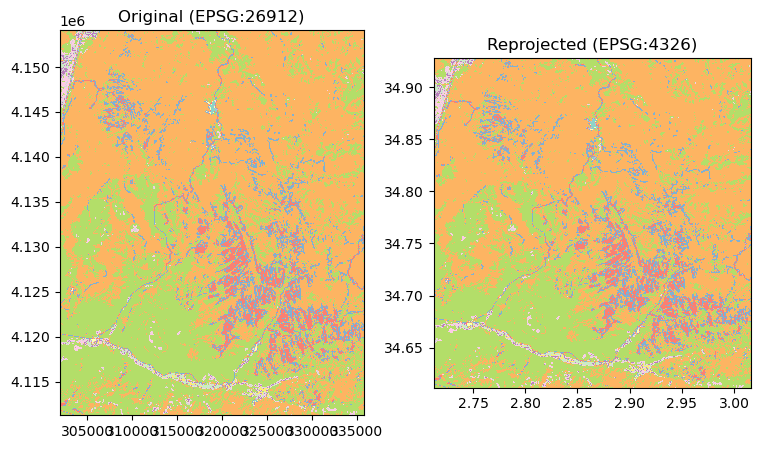

In [45]:
#| label: fig-raster-reproject-nlcd
#| fig-cap: Reprojecting a categorical raster using nearest neighbor resampling

fig, axes = plt.subplots(ncols=2, figsize=(9,5))
show(src_nlcd, ax=axes[0], cmap='Set3')
show(src_nlcd_4326, ax=axes[1], cmap='Set3')
axes[0].set_title('Original (EPSG:26912)')
axes[1].set_title('Reprojected (EPSG:4326)');

在上面的示例中，我们使用“rasterio.warp.calculate_default_transform”自动计算最佳（即保留最多信息）目标网格。
当目标栅格空间属性没有特定要求时，这适用。
也就是说，我们不需要获得特定的原点和分辨率，而只是希望尽可能地保留栅格值。
为此，“calculate_default_transform”“尝试”保持目标栅格的范围和分辨率与源栅格尽可能相似。
然而，在其他情况下，我们需要将栅格重新投影到特定的“模板”中，以便它与我们在分析中使用的其他栅格相对应。
在以下代码部分中，我们再次重新投影“nlcd.tif”栅格，但这次使用“nlcd_4326.tif”重新投影结果作为“模板”来演示此替代工作流程。

首先，我们创建与“模板”栅格的连接以读取其元数据：

In [46]:
template = rasterio.open('output/nlcd_4326.tif')
template.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 1200,
 'height': 1248,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00025326212175780043, 0.0, 2.7120438858942424,
        0.0, -0.00025326212175780043, 34.92789350789737)}

然后，我们使用此元数据创建到目标栅格的写入模式连接，这意味着重采样结果将具有与“模板”相同的元数据：

In [47]:
dst_nlcd_2 = rasterio.open('output/nlcd_4326_2.tif', 'w', **template.meta)

现在，我们可以重新采样并写入结果：

In [48]:
rasterio.warp.reproject(
    source=rasterio.band(src_nlcd, 1),
    destination=rasterio.band(dst_nlcd_2, 1),
    src_transform=src_nlcd.transform,
    src_crs=src_nlcd.crs,
    dst_transform=dst_nlcd_2.transform,
    dst_crs=dst_nlcd_2.crs,
    resampling=rasterio.warp.Resampling.nearest
)

(Band(ds=<open DatasetWriter name='output/nlcd_4326_2.tif' mode='w'>, bidx=1, dtype='uint8', shape=(1248, 1200)),
 Affine(0.00025326212175780043, 0.0, 2.7120438858942424,
        0.0, -0.00025326212175780043, 34.92789350789737))

In [49]:
dst_nlcd_2.close()

当然，在这种情况下，输出“nlcd_4326.tif”和“nlcd_4326_2.tif”是相同的，因为我们使用相同的“模板”和相同的源数据：

In [50]:
d = rasterio.open('output/nlcd_4326.tif').read(1) == rasterio.open('output/nlcd_4326_2.tif').read(1)
d

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [51]:
np.all(d)

True

不同之处在于，在第一个示例中，我们使用“rasterio.warp.calculate_default_transform”自动计算模板，而在第二个示例中，我们使用现有栅格作为“模板”。

重要的是，当模板栅格的分辨率比源栅格的“粗略”程度高得多时，：

* `rasterio.warp.Resampling.average`（对于连续栅格），或者
* `rasterio.warp.Resampling.mode`（对于分类栅格）

应使用重采样方法，而不是“rasterio.warp.Resampling.nearest”。 否则，大部分数据将会丢失，因为“最近”方法只能捕获每个目标栅格像素的一个像素值。

重新投影连续栅格（使用数字值或在本例中为整数值）遵循几乎相同的过程。 下面通过来自航天飞机雷达地形测量任务 (SRTM) 的“srtm.tif”进行了演示，它用 WGS84 CRS 表示海拔高度（以米为单位）。

我们将把这个数据集重新投影到投影的 CRS 中，但不使用适合分类数据的最近邻方法。 相反，我们将使用双线性方法，该方法根据原始栅格中四个最近的像元计算输出像元值。 投影数据集中的值是这四个像元的值的距离加权平均值：输入像元距离输出像元的中心越近，其权重越大。 以下代码部分创建一个表示 WGS 84 / UTM 区域 12N 的文本字符串，并使用双线性方法将栅格重新投影到此 CRS 中。 代码实际上是相同的，除了更改源文件名和目标文件名，并将“nearest”替换为“bilinear”：

In [52]:
dst_crs = 'EPSG:32612'
dst_transform, dst_width, dst_height = rasterio.warp.calculate_default_transform(
    src_srtm.crs,
    dst_crs,
    src_srtm.width,
    src_srtm.height,
    *src_srtm.bounds
)
dst_kwargs = src_srtm.meta.copy()
dst_kwargs.update({
    'crs': dst_crs,
    'transform': dst_transform,
    'width': dst_width,
    'height': dst_height
})
dst_srtm = rasterio.open('output/srtm_32612.tif', 'w', **dst_kwargs)
rasterio.warp.reproject(
    source=rasterio.band(src_srtm, 1),
    destination=rasterio.band(dst_srtm, 1),
    src_transform=src_srtm.transform,
    src_crs=src_srtm.crs,
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    resampling=rasterio.warp.Resampling.bilinear
)
dst_srtm.close()

@fig-raster-reproject-srtm 显示输入和重新投影的 SRTM 栅格。

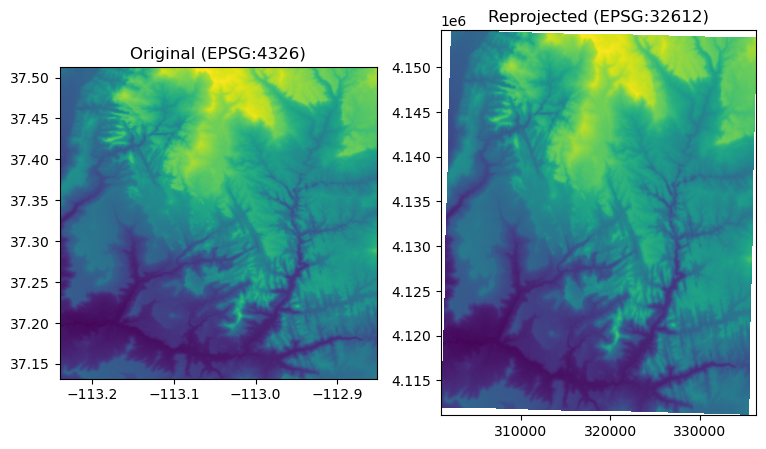

In [53]:
#| label: fig-raster-reproject-srtm
#| fig-cap: Reprojecting a continuous raster using bilinear resampling

fig, axes = plt.subplots(ncols=2, figsize=(9,5))
show(src_srtm, ax=axes[0])
show(rasterio.open('output/srtm_32612.tif'), ax=axes[1])
axes[0].set_title('Original (EPSG:4326)')
axes[1].set_title('Reprojected (EPSG:32612)');